# Short-term Memory

In this coding session we'll implement a **short-term memory**, from a very basic solution to more advanced approaches.

- Short term Memory: Working Memory
    - Refers to all the context available to llm at the time of generating a response.
- Long term memory: Refer to external database
    - LLM access when it's needed. 


### Our Short-term memory involves three steps
1. Store all the messages into Graph State
2. Summarize the conversation to reduce the token consumption
3. Use external database to store Graph State

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt langgraph-checkpoint-sqlite langchain-chroma langchain-community

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


## A first implementation

Let's implement a very simple workflow to understand how the logic works. We'll start by creating a simple node that contains the LLM call.

In [3]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

llm = ChatOpenAI(model="gpt-4o-mini")

def assistant(state: MessagesState):
  return {"messages": [llm.invoke(state["messages"])]}

Now, time to build the Graph.

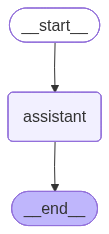

In [4]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

# Graph
workflow = StateGraph(MessagesState)

# Define node
workflow.add_node("assistant", assistant)

# Define edges: these determine how the control flow moves
workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", END)

graph = workflow.compile()

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's invoke it.

In [5]:
messages = [
    HumanMessage(content="Hello, I'm Miguel!")
]

messages = graph.invoke({"messages": messages})

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Hello, I'm Miguel!
================================== Ai Message ==================================

Hello, Miguel! How can I assist you today?


But ... what happens if I ask again my name?

In [6]:
messages = [
    HumanMessage(content="Remember my name?")
]

messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal information or previous interactions. But I’m here to help! How can I assist you today?


Did you guess it? Memory is not working for this Graph!

>This is because **state is transient to a single graph execution.**

Of course, this limits our ability to have multi-turn conversations with interruptions.

> We can use persistence to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph_memory = workflow.compile(checkpointer=memory)

When we use memory, we need to specify a thread_id.

This thread_id will store our collection of graph states.

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the thread_id

Check the image below! 👇

<img src="https://drive.google.com/uc?id=15myCwBmiCAfnHqnMAO3IvToXpNBsG6vm" alt="Alt text" width="1000"/>

Let's try again defining a `thread_id` for our interaction.

In [9]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

messages = [
    HumanMessage(content="Hello, my name is Miguel!")
]

# The difference from before is that now we need to pass the config
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Hello, my name is Miguel!
================================== Ai Message ==================================

Hello, Miguel! How can I assist you today?


Let's see if the assistant remembers us now ...

In [10]:
messages = [HumanMessage(content="Hey, can you say my name? Do you remember it?")]

messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Hello, my name is Miguel!
================================== Ai Message ==================================

Hello, Miguel! How can I assist you today?
================================ Human Message =================================

Hey, can you say my name? Do you remember it?
================================== Ai Message ==================================

Yes, I remember your name is Miguel! How can I help you today?


Adding the checkpointer fixes the issue! Our Graph has memory now!

## Adding a summarisation step

The problem with this approach is that if we have very long conversations, the number of tokens that need to go into the context will be huge!

That's why we need to add a summarisation node.

First, we'll define the new graph state. In this case, in addition to the `messages` property, we also need a `summary` property, to allocate the summary of the conversation so far.

In [11]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

We'll set up a node to call our LLM, adding a summary to the prompt if one's available.

In [12]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):

  # Get summary if it exists
  summary = state.get("summary", "")

  # If there is summary, then we add it to the System Prompt
  if summary:

    # Add summary to system message
    system_message = f"Summary of conversation earlier: {summary}"

    # Append summary to any newer messages
    messages = [SystemMessage(content=system_message)] + state["messages"]

  else:
    messages = state["messages"]

  response = llm.invoke(messages)
  return {"messages": response}

Now, we'll create a node that generates a summary.

> Just a heads-up: we'll use `RemoveMessage` here to clean up the state once the summary is created.



In [13]:
def summarize_conversation(state: State):

  # First, we get any existing summary
  summary = state.get("summary", "")

  # Create our summarization prompt
  if summary:

      # A summary already exists
      summary_message = (
          f"This is summary of the conversation to date: {summary}\n\n"
          "Extend the summary by taking into account the new messages above:"
      )

  else:
      summary_message = "Create a summary of the conversation above:"

  # Add prompt to our history
  messages = state["messages"] + [HumanMessage(content=summary_message)]
  response = llm.invoke(messages)

  # Delete all but the 2 most recent messages
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

  return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge that checks the conversation length to decide whether a summary should be generated.


In [14]:
from typing_extensions import Literal

def should_continue(state: State) -> Literal ["summarize_conversation", END]:
  """This node determines whether to end or summarise the conversation"""

  messages = state["messages"]

  # If there are more than six messages, then we summarize the conversation
  if len(messages) > 20:
      return "summarize_conversation"

  # Otherwise we can just end
  return END

Now, let's build the graph as we did before.

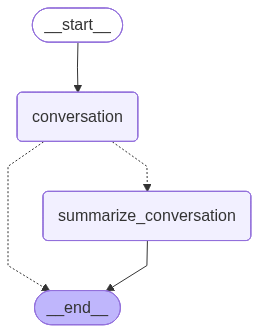

In [15]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding External Persistence

But what if we want our chatbot to have memory that **sticks around indefinitely**?

That's where a more **advanced checkpointer** comes in—one that can work with external databases.

In this case, we'll walk through how to use **SQLite** as our checkpointer.

In [16]:
import sqlite3

# Define the path for persisting the db
db_path = "example.db"

conn = sqlite3.connect(db_path, check_same_thread=False)

Now, let's define a different checkpointer (the checkpointer from the previous workflow was `in memory`), that's going to actually persist the graph state into Sqlite.

In [17]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

We can compile the graph we defined previously, but with a different checkpointer now.

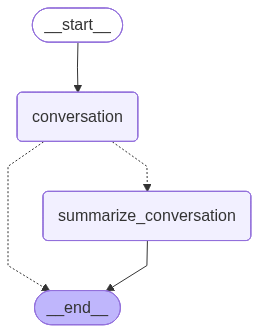

In [18]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, let's interact with our graph.

In [19]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Hello, my name is Miguel!")]

# Run
messages = graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Miguel!
================================== Ai Message ==================================

Hello, Miguel! It's nice to meet you. How can I assist you today?


Even if we restart the notebook kernel, we'll still be able to load data from the SQLite database on disk!

> Restart the notebook and run the next cells!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt langgraph-checkpoint-sqlite

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


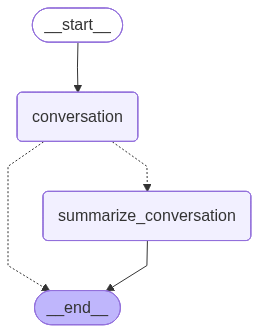

In [3]:
from IPython.display import Image, display
from typing_extensions import Literal

import sqlite3

from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_openai import ChatOpenAI


class State(MessagesState):
    summary: str


def call_model(state: State):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": response}


def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}


def should_continue(state: State) -> Literal ["summarize_conversation", END]:
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_conversation"

    return END


# Create the ChatModel
llm = ChatOpenAI(model="gpt-4o-mini")

# Define the connection to the existing Sqlite database
db_path = "example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

memory = SqliteSaver(conn)


# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Hey, can you say my name? Do you remember it?")]

# Run
messages = graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Miguel!
================================== Ai Message ==================================

Hello, Miguel! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

Hey, can you say my name? Do you remember it?
================================== Ai Message ==================================

Yes, your name is Miguel! How can I help you today?


Even if we've restarted the session, LangGraph is able to get the past interactions from Sqlite!